[Reference](https://medium.com/@kylejones_47003/time-series-analysis-with-statsmodels-in-python-ea0fce203c0a)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# Generate or Load Time Series Data

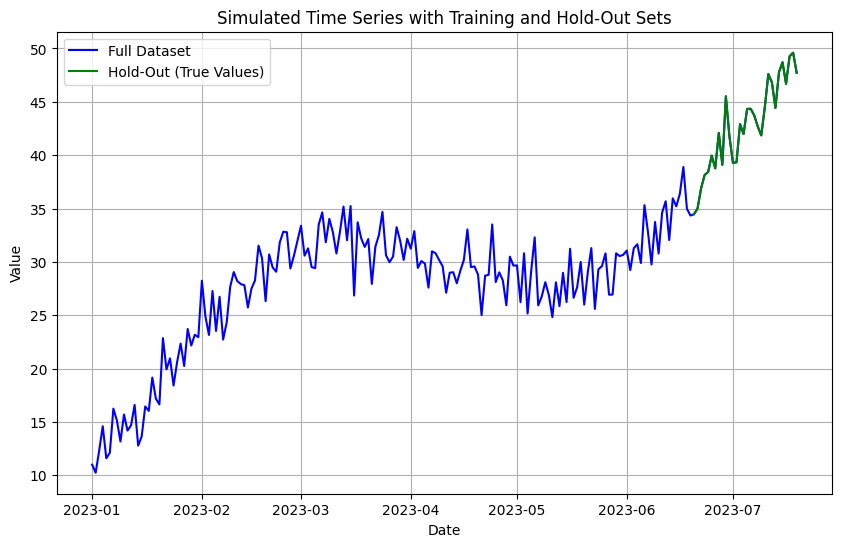

In [2]:
"""
Generate or Load Time Series Data
Simulate a time series with trend and seasonality
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate Simulated Time Series Data
np.random.seed(42)
n = 200
time = pd.date_range(start="2023-01-01", periods=n, freq="D")
trend = np.linspace(10, 50, n)
seasonality = 10 * np.sin(np.linspace(0, 2 * np.pi, n))
noise = np.random.normal(0, 2, n)
data = trend + seasonality + noise

# Create a DataFrame; split the data
df = pd.DataFrame({"date": time, "value": data})
df.set_index("date", inplace=True)

hold_out_days = 30
train = df.iloc[:-hold_out_days]
hold_out = df.iloc[-hold_out_days:]

# Plot the Data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["value"], label="Full Dataset", color="Blue")
plt.plot(hold_out.index, hold_out["value"], label="Hold-Out (True Values)", color="Green")

plt.title("Simulated Time Series with Training and Hold-Out Sets")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.savefig("simulated_time_series.png")
plt.show()

# Time Series Decomposition

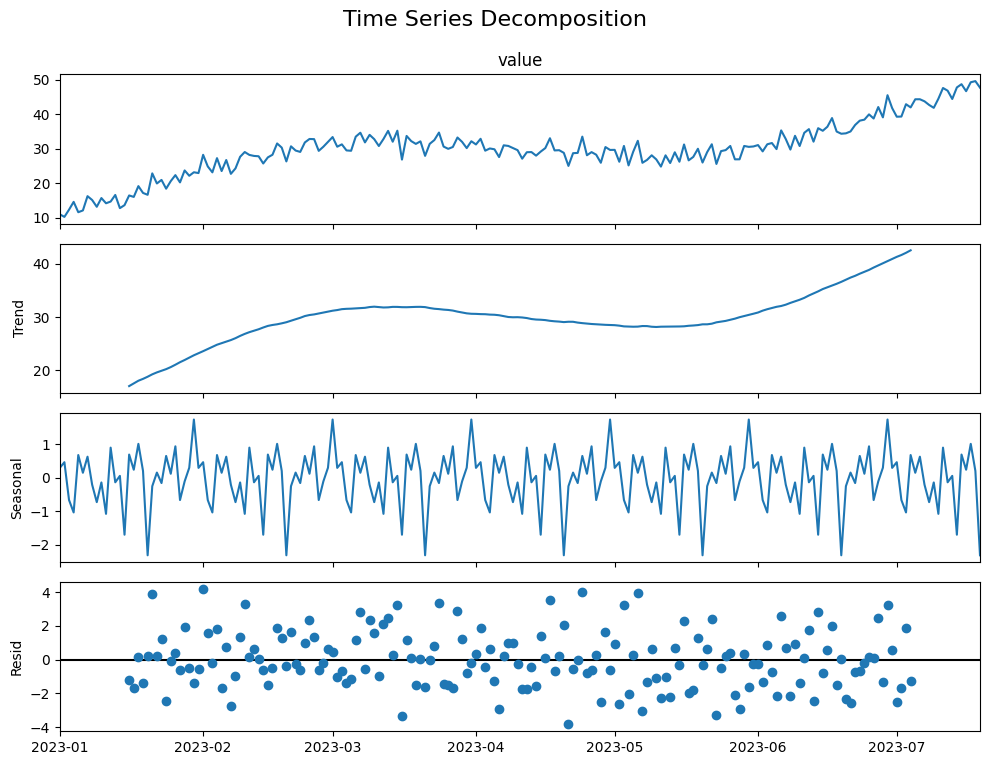

In [3]:
"""
Time Series Decomposition
Use seasonal_decompose to split the series into trend, seasonal, and residual components.
"""
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df["value"], model="additive", period=30)

# Plot the components
fig = decomposition.plot()
fig.set_size_inches(10, 8)  # Adjust the figure size
plt.suptitle("Time Series Decomposition", fontsize=16, y=0.95)  # Adjust title position
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Prevent overlap of title with subplots
plt.savefig("time_series_decomposition.png")
plt.show()

# Check for Stationarity

In [4]:
"""
Check for Stationarity
Use the Augmented Dickey-Fuller (ADF) test to assess stationarity.
"""

from statsmodels.tsa.stattools import adfuller
# Perform ADF test
result = adfuller(df["value"])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"P-Value: {result[1]:.4f}")
if result[1] > 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -0.5022
P-Value: 0.8916
The time series is non-stationary.


# Autocorrelation and Partial Autocorrelation

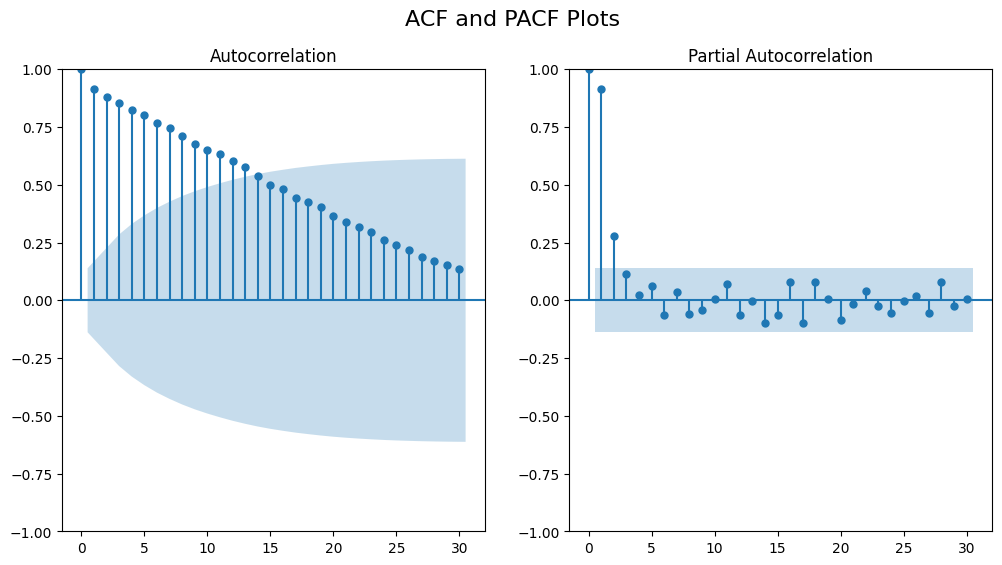

In [5]:
"""
Autocorrelation and Partial Autocorrelation
Visualize the ACF and PACF to determine lag dependencies.
"""

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(df["value"], lags=30, ax=axes[0])
plot_pacf(df["value"], lags=30, ax=axes[1])
plt.suptitle("ACF and PACF Plots", fontsize=16)
plt.savefig("acf_pacf_plots.png")
plt.show()

# Fit an ARIMA Model

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  200
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -438.288
Date:                Thu, 16 Jan 2025   AIC                            886.577
Time:                        12:50:31   BIC                            903.043
Sample:                    01-01-2023   HQIC                           893.241
                         - 07-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9834      0.170     -5.782      0.000      -1.317      -0.650
ar.L2         -0.2046      0.107     -1.917      0.055      -0.414       0.005
ma.L1          0.2896      0.165      1.756      0.0

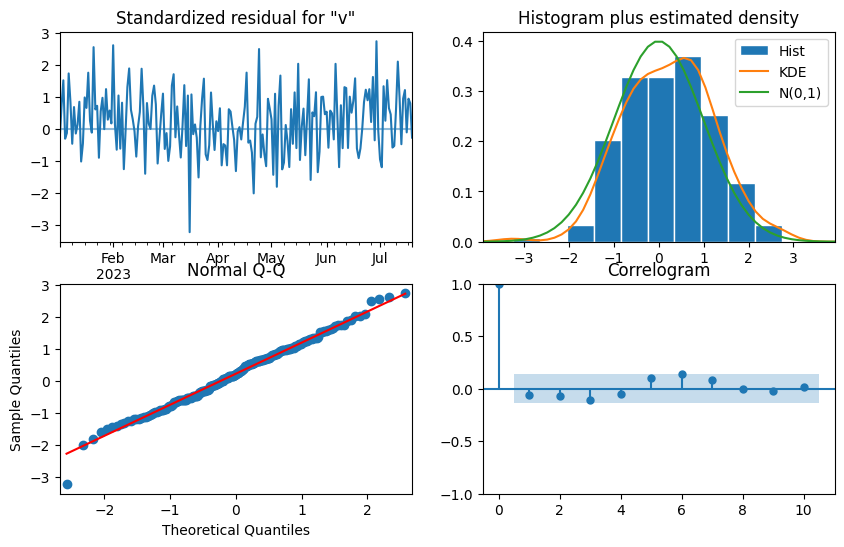

In [6]:
"""
Fit an ARIMA Model
Fit an ARIMA model to the data for forecasting.
"""

from statsmodels.tsa.arima.model import ARIMA
# Fit an ARIMA(2,1,2) model
model = ARIMA(df["value"], order=(2, 1, 2))
arima_result = model.fit()

print(arima_result.summary())
# Plot the residuals
arima_result.plot_diagnostics(figsize=(10, 6))
plt.savefig("arima_residuals_diagnostics.png")
plt.show()

# Forecast Future Values

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Mean Absolute Percentage Error (MAPE): 16.479%


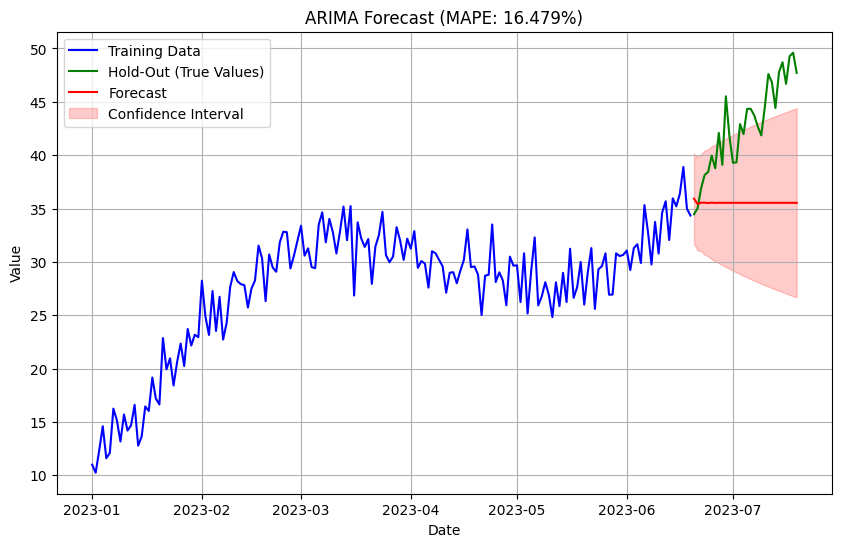

In [8]:
"""
ARIMA
Forecast the 30 days that were held out
"""

from sklearn.metrics import mean_absolute_percentage_error

# Fit ARIMA Model on Training Data
model = ARIMA(train["value"], order=(2, 1, 2), freq="D")  # Explicitly set freq="D"
arima_result = model.fit()

# Forecast Future Values for Hold-Out Period
forecast = arima_result.get_forecast(steps=hold_out_days)
forecast_index = hold_out.index  # Use the same index as the hold-out set
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Calculate MAPE on Hold-Out Set
mape = mean_absolute_percentage_error(hold_out["value"], forecast_mean)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3%}")

# Plot the Results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train["value"], label="Training Data", color="Blue")
plt.plot(hold_out.index, hold_out["value"], label="Hold-Out (True Values)", color="Green")
plt.plot(forecast_index, forecast_mean, label="Forecast", color="Red")
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="Red", alpha=0.2, label="Confidence Interval")
plt.title(f"ARIMA Forecast (MAPE: {mape:.3%})")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.savefig("arima_forecast_holdout.png")
plt.show()

# Holt-Winters Exponential Smoothing

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Holt-Winters MAPE: 16.109%


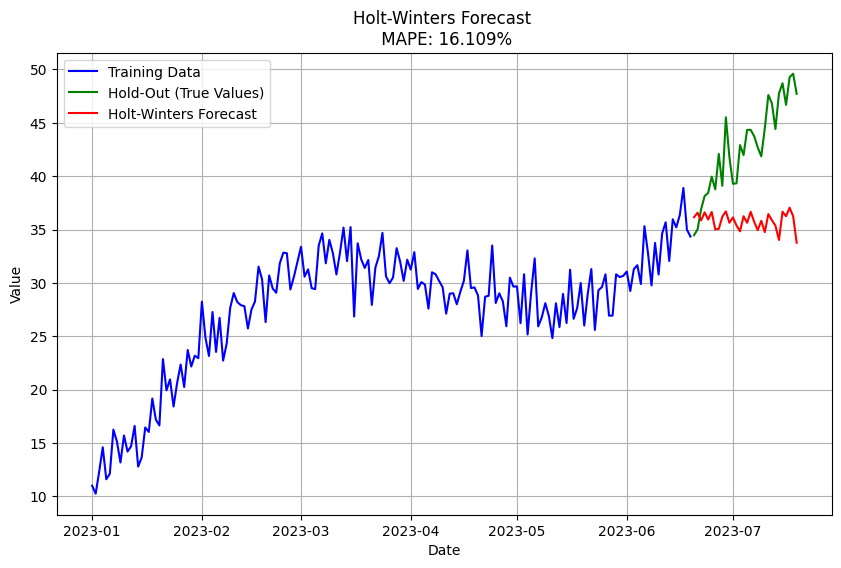

In [9]:
"""
Holt-Winters Exponential Smoothing
"""

# Apply Holt-Winters Exponential Smoothing
hw_model = ExponentialSmoothing(
    train["value"],
    seasonal="add",
    seasonal_periods=30
).fit()

hw_forecast = hw_model.forecast(steps=hold_out_days)

# Calculate MAPE on Hold-Out Set
mape_hw = mean_absolute_percentage_error(hold_out["value"], hw_forecast)
print(f"Holt-Winters MAPE: {mape_hw:.3%}")

# Plot the Results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train["value"], label="Training Data", color="Blue")
plt.plot(hold_out.index, hold_out["value"], label="Hold-Out (True Values)", color="Green")
plt.plot(hold_out.index, hw_forecast, label="Holt-Winters Forecast", color="Red")
plt.title(f"Holt-Winters Forecast \n MAPE: {mape_hw:.3%}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.savefig("holt_winters_forecast.png")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1416 - val_loss: 0.0948
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0266 - val_loss: 0.0034
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - val_loss: 0.0116
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0061
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0055
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - v

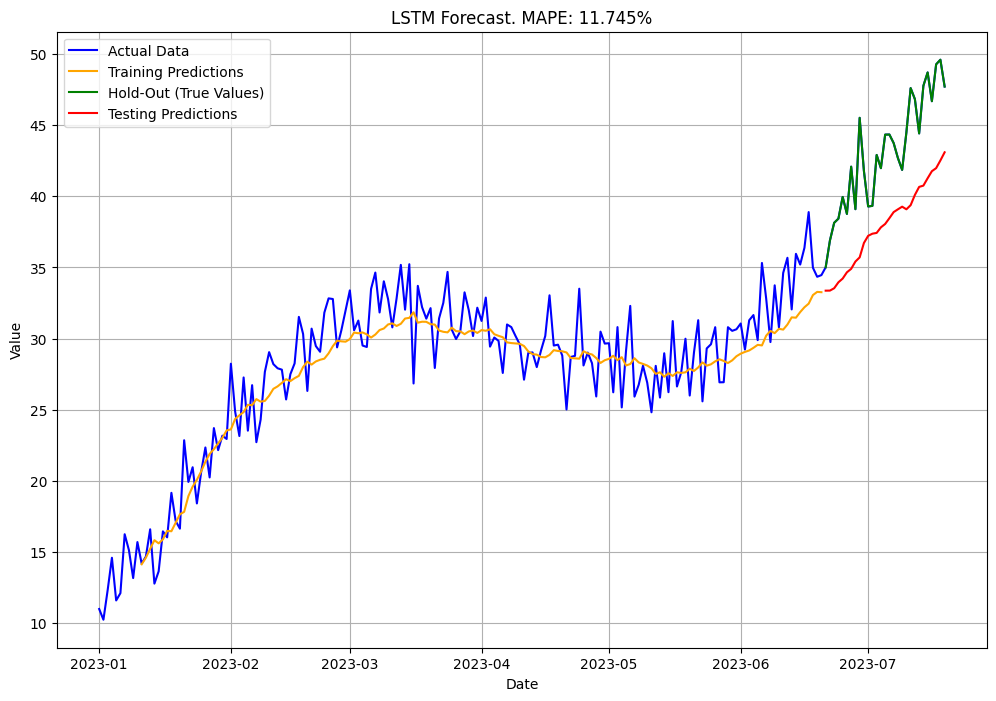

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Prepare Data for LSTM
scaler = MinMaxScaler()
df["value"] = scaler.fit_transform(df["value"].values.reshape(-1, 1))

def create_lagged_features(data, lag):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(data[i+lag])
    return np.array(X), np.array(y)

lag = 10  # Number of past observations to use for prediction
X, y = create_lagged_features(df["value"].values, lag)

X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing sets
train_size = int(0.85 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build, Fit, Predict and Evaluate the LSTM Model
model = tf.keras.Sequential([
    LSTM(50, activation='relu', input_shape=(lag, 1)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1, validation_split=0.1)

y_pred_lstm = model.predict(X_test)
y_pred_lstm_inverse = scaler.inverse_transform(y_pred_lstm)  # Inverse scaling for comparison
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Reconstruct training predictions for plotting
train_predictions = model.predict(X_train)
train_predictions_inverse = scaler.inverse_transform(train_predictions)

# Calculate MAPE for the test set
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_lstm_inverse)
print(f"LSTM MAPE: {mape:.3%}")

# Plot the Results
plt.figure(figsize=(12, 8))
plt.plot(df.index, scaler.inverse_transform(df["value"].values.reshape(-1, 1)), label="Actual Data", color="Blue")
train_index = df.index[lag:train_size + lag]
plt.plot(train_index, train_predictions_inverse, label="Training Predictions", color="Orange")
test_index = df.index[train_size + lag:]
plt.plot(test_index, y_test_inverse, label="Hold-Out (True Values)", color="Green")
plt.plot(test_index, y_pred_lstm_inverse, label="Testing Predictions", color="Red")
plt.title(f'LSTM Forecast. MAPE: {mape:.3%}')
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.savefig("LSTM_forecast_with_holdout.png")
plt.show()